In [1]:
import copy
import json
import random

import numpy as np 
from PIL import Image

from utils import check_results, display_results

In [13]:
def calculate_iou(gt_bbox, pred_bbox):
    """
    calculate iou 
    args:
    - gt_bbox [array]: 1x4 single gt bbox
    - pred_bbox [array]: 1x4 single pred bbox
    returns:
    - iou [float]: iou between 2 bboxes
    """
    xmin = np.max([gt_bbox[0], pred_bbox[0]])
    ymin = np.max([gt_bbox[1], pred_bbox[1]])
    xmax = np.min([gt_bbox[2], pred_bbox[2]])
    ymax = np.min([gt_bbox[3], pred_bbox[3]])
    
    intersection = max(0, xmax - xmin + 1) * max(0, ymax - ymin + 1)
    gt_area = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    pred_area = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    
    union = gt_area + pred_area - intersection
    return intersection / union, [xmin, ymin, xmax, ymax]


def hflip(img, bboxes):
    """
    horizontal flip of an image and annotations
    args:
    - img [PIL.Image]: original image
    - bboxes [list[list]]: list of bounding boxes
    return:
    - flipped_img [PIL.Image]: horizontally flipped image
    - flipped_bboxes [list[list]]: horizontally flipped bboxes
    """
    # flip image
    flipped_img = img.transpose(Image.FLIP_LEFT_RIGHT)
    w, h = img.size
    
    # flip bboxes
    bboxes = np.array(bboxes)
    flipped_bboxes = copy.copy(bboxes)
    flipped_bboxes[:, 1] = w - bboxes[:, 3]
    flipped_bboxes[:, 3] = w - bboxes[:, 1]
    return flipped_img, flipped_bboxes


def resize(img, boxes, size):
    """
    resized image and annotations
    args:
    - img [PIL.Image]: original image
    - boxes [list[list]]: list of bounding boxes
    - size [array]: 1x2 array [width, height]
    returns:
    - resized_img [PIL.Image]: resized image
    - resized_boxes [list[list]]: resized bboxes
    """
    # resize image
    resized_image = img.resize(size)
    w, h = img.size
    ratiow = size[0] / w
    ratioh = size[1] / h
    
    # resize bboxes
    boxes = np.array(boxes)
    resized_boxes = copy.copy(boxes)
    resized_boxes[:, [0, 2]] = resized_boxes[:, [0, 2]] * ratioh
    resized_boxes[:, [1, 3]] = resized_boxes[:, [1, 3]] * ratiow
    return resized_image, resized_boxes


def random_crop(img, boxes, classes, crop_size, min_area=100):
    """
    random cropping of an image and annotations
    args:
    - img [PIL.Image]: original image
    - boxes [list[list]]: list of bounding boxes
    - classes [list]: list of classes
    - crop_size [array]: 1x2 array [width, height]
    - min_area [int]: min area of a bbox to be kept in the crop
    returns:
    - cropped_img [PIL.Image]: cropped image
    - cropped_boxes [list[list]]: cropped bboxes
    - cropped_classes [list]: cropped classes
    """
    # crop coordinates
    w, h = img.size
    x1 = np.random.randint(0, w - crop_size[0])
    y1 = np.random.randint(0, h - crop_size[1])
    x2 = x1 + crop_size[0]
    y2 = y1 + crop_size[1]

    # crop the image
    cropped_image = img.crop((x1, y1, x2 ,y2))

    # calculate iou between boxes and crop
    cropped_boxes = []
    cropped_classes = []
    for bb, cl in zip(boxes, classes):
        iou, inter_coord = calculate_iou(bb, [y1, x1, y2, x2])
        # some of the bbox overlap with the crop
        if iou > 0:
            # we need to check the size of the new coord
            area = (inter_coord[3] - inter_coord[1]) * (inter_coord[2] - inter_coord[0])
            if area > min_area:
                xmin = inter_coord[1] - x1
                ymin = inter_coord[0] - y1
                xmax = inter_coord[3] - x1
                ymax = inter_coord[2] - y1
                cropped_box = [ymin, xmin, ymax, xmax]
                cropped_boxes.append(cropped_box)
                cropped_classes.append(cl)
    return cropped_image, cropped_boxes, cropped_classes


# if __name__ == '__main__':
#     # fix seed to check results
#     np.random.seed(48)

#     # open annotations 
#     with open('data/ground_truth.json') as f:
#         ground_truth = json.load(f)

#     # filter annotations and open image
#     filename = 'segment-12208410199966712301_4480_000_4500_000_with_camera_labels_79.png'
#     gt_boxes = [g['boxes'] for g in ground_truth if g['filename'] == filename][0]
#     gt_classes = [g['classes'] for g in ground_truth if g['filename'] == filename][0]
#     img = Image.open(f'data/images/{filename}')

#     # check horizontal flip
#     flipped_img, flipped_bboxes = hflip(img, gt_boxes)
#     display_results(img, gt_boxes, flipped_img, flipped_bboxes)
#     check_results(flipped_img, flipped_bboxes, aug_type='hflip')

#     # check resize
#     resized_image, resized_boxes = resize(img, gt_boxes, size=[640, 640])
#     display_results(img, gt_boxes, resized_image, resized_boxes)
#     check_results(resized_image, resized_boxes, aug_type='resize')

#     # check random crop
#     cropped_image, cropped_boxes, cropped_classes = random_crop(img, gt_boxes, gt_classes, [512, 512], min_area=100)
#     display_results(img, gt_boxes, cropped_image, cropped_boxes)
#     check_results(cropped_image, cropped_boxes, aug_type='random_crop', classes=cropped_classes)

In [3]:
# fix seed to check results
np.random.seed(48)

# open annotations 
with open('data/ground_truth.json') as f:
    ground_truth = json.load(f)

In [5]:
ground_truth[0]

{'boxes': [[576, 545, 617, 584],
  [551, 628, 573, 651],
  [508, 437, 646, 552],
  [584, 1021, 679, 1057],
  [521, 716, 627, 756],
  [550, 711, 600, 729],
  [586, 558, 630, 617],
  [614, 76, 653, 105],
  [567, 910, 598, 927],
  [604, 1188, 826, 1244],
  [561, 542, 579, 563],
  [557, 654, 583, 684],
  [589, 1190, 655, 1240],
  [562, 559, 578, 578],
  [603, 1723, 857, 1821],
  [578, 881, 686, 923],
  [586, 942, 671, 971],
  [581, 996, 661, 1023],
  [597, 1105, 761, 1250],
  [586, 625, 646, 703],
  [558, 892, 589, 908],
  [593, 907, 684, 941],
  [577, 987, 650, 1014],
  [569, 1593, 613, 1613],
  [577, 1109, 665, 1129],
  [560, 942, 601, 963],
  [574, 1107, 665, 1149],
  [525, 321, 682, 466],
  [599, 1151, 809, 1206],
  [560, 608, 594, 642],
  [581, 512, 639, 537],
  [538, 685, 577, 706],
  [541, 543, 581, 591],
  [611, 94, 671, 123],
  [582, 1069, 681, 1110],
  [562, 900, 604, 918],
  [588, 1723, 900, 1872],
  [557, 870, 608, 883],
  [565, 956, 633, 983],
  [644, 0, 912, 192],
  [545, 643

In [6]:
# filter annotations and open image
filename = 'segment-12208410199966712301_4480_000_4500_000_with_camera_labels_79.png'

gt_boxes = [g['boxes'] for g in ground_truth if g['filename'] == filename][0]
gt_classes = [g['classes'] for g in ground_truth if g['filename'] == filename][0]

In [7]:
gt_boxes[0]

[810, 0, 1280, 393]

In [8]:
gt_classes[0]

1

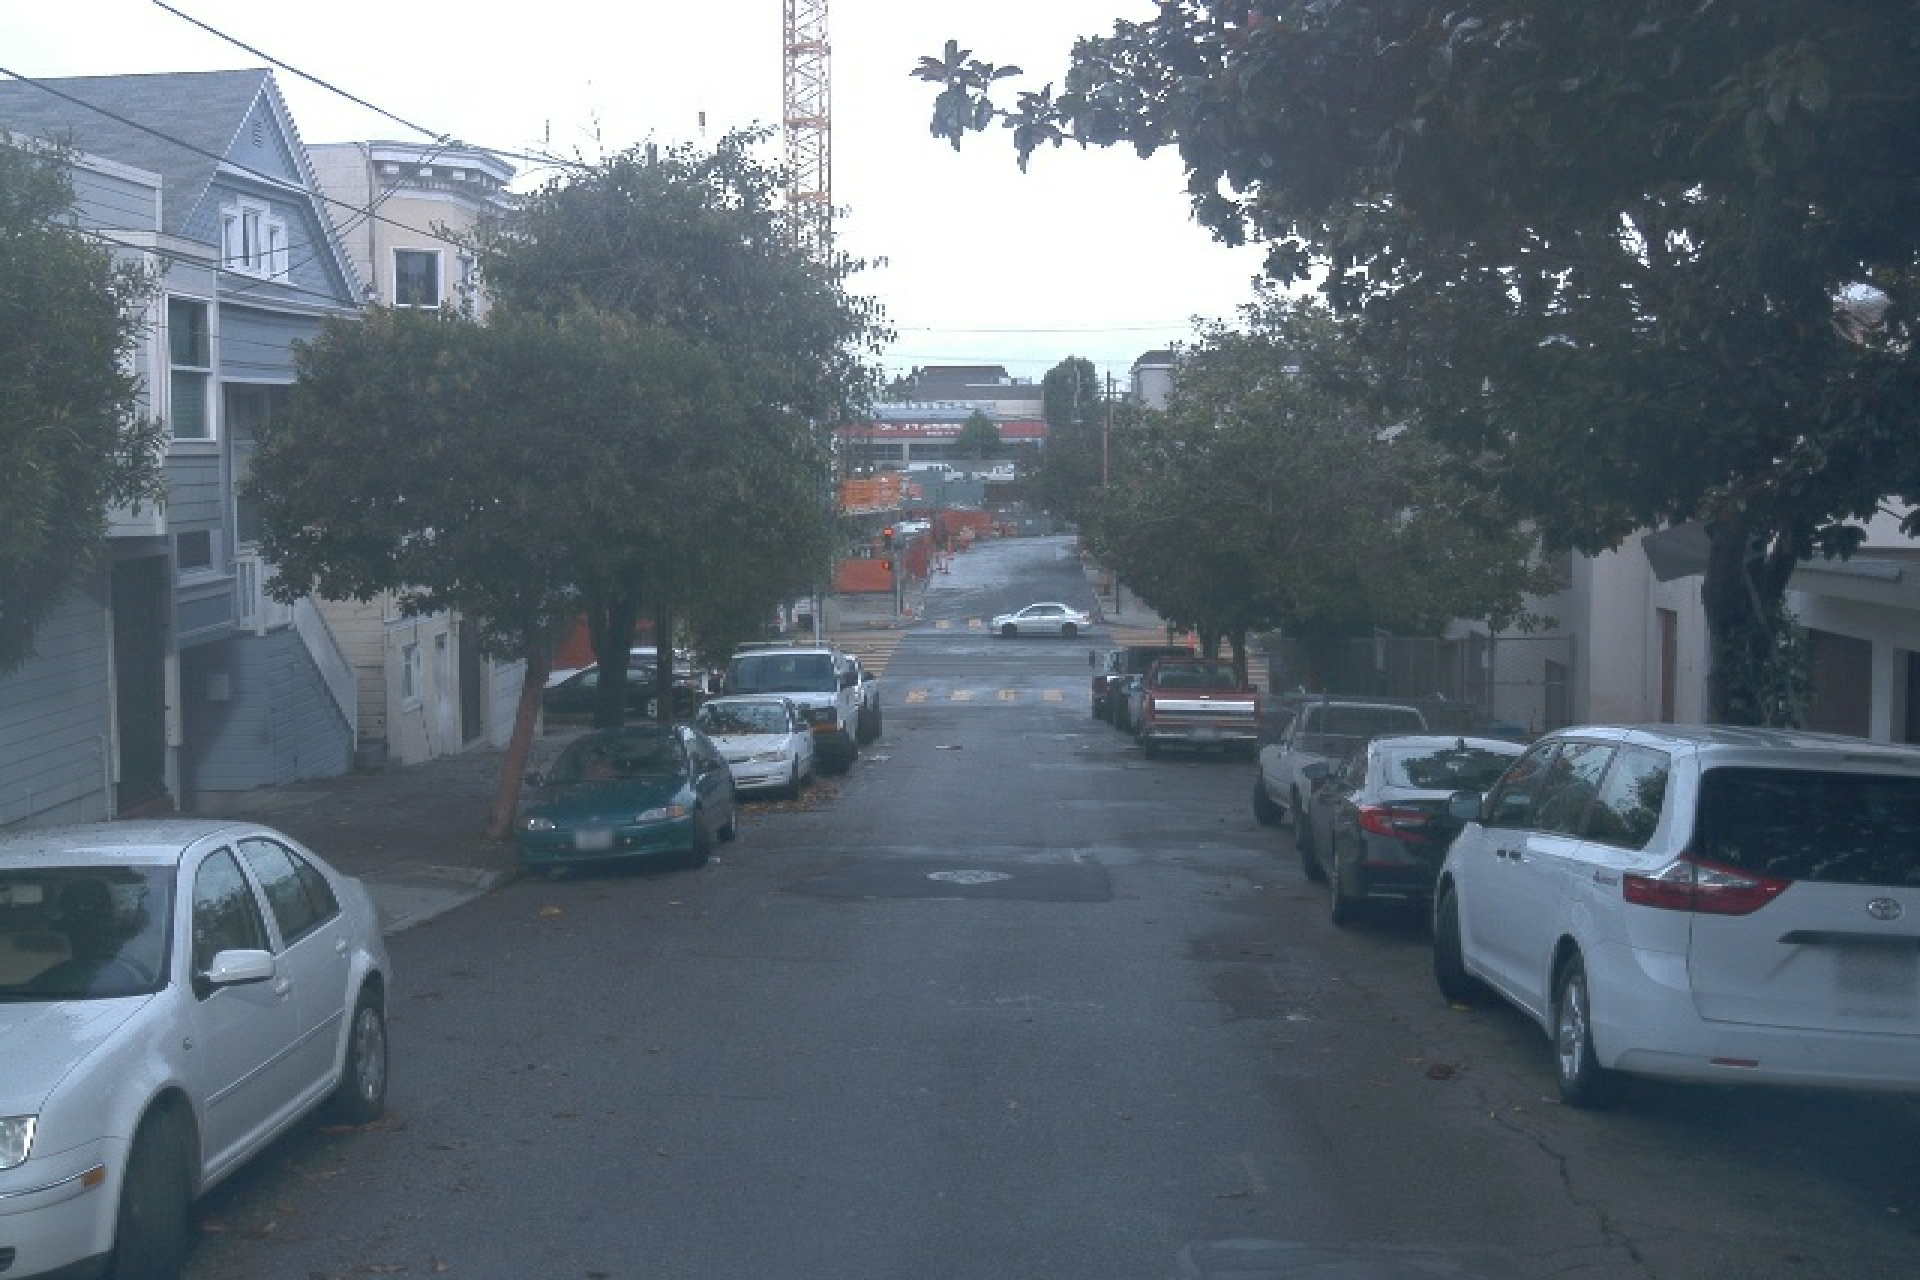

In [10]:
img = Image.open(f'data/images/{filename}')
img

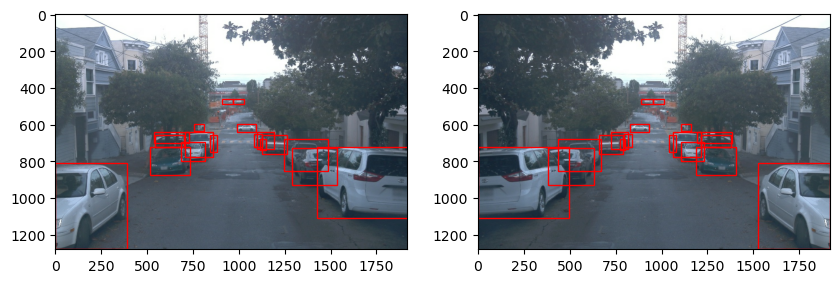

Horizontal flip is working


In [14]:
# check horizontal flip
flipped_img, flipped_bboxes = hflip(img, gt_boxes)
display_results(img, gt_boxes, flipped_img, flipped_bboxes)
check_results(flipped_img, flipped_bboxes, aug_type='hflip')

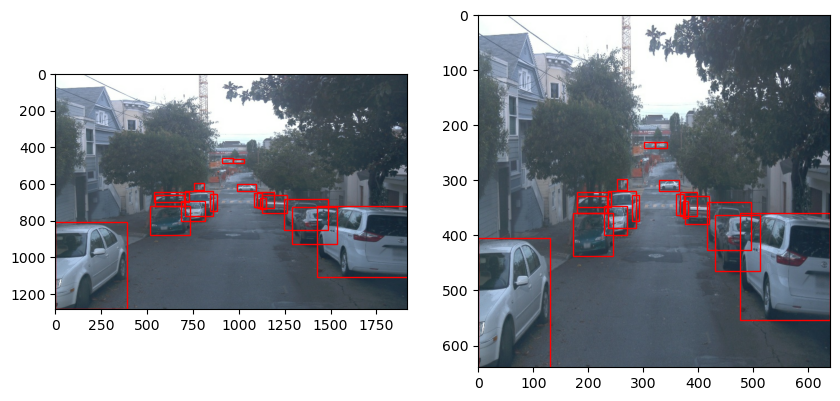

Resizing is working


In [15]:
# check resize
resized_image, resized_boxes = resize(img, gt_boxes, size=[640, 640])
display_results(img, gt_boxes, resized_image, resized_boxes)
check_results(resized_image, resized_boxes, aug_type='resize')

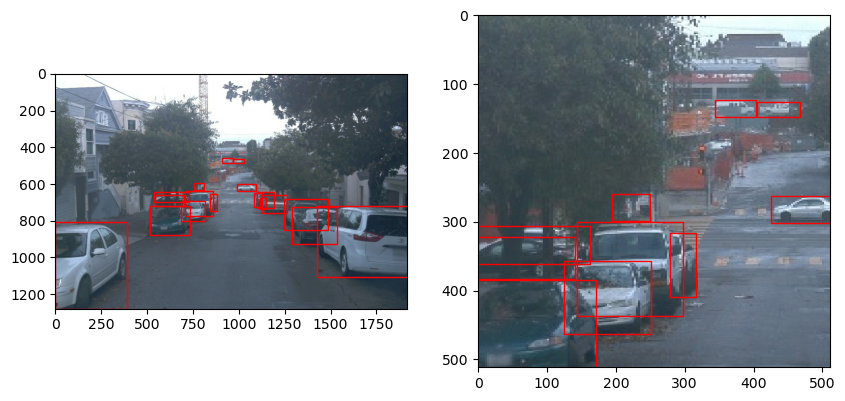

Cropping is working


In [16]:
# check random crop
cropped_image, cropped_boxes, cropped_classes = random_crop(img, gt_boxes, gt_classes, [512, 512], min_area=100)
display_results(img, gt_boxes, cropped_image, cropped_boxes)
check_results(cropped_image, cropped_boxes, aug_type='random_crop', classes=cropped_classes)